# Portfolio Optimization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy import stats
from scipy.optimize import minimize
import warnings
from datetime import datetime, timedelta

warnings.filterwarnings('ignore')
%matplotlib inline

**Objective:** Build a diverse portfolio of assets and measure its performance against the broader market

**Steps**
1. Select the stocks that will form the portfolio and collect daily price data for a year.
2. Examine return characteristics of the stock (return, volatility)
3. Optimize portfolio allocation to maximize risk-adjusted return (Sharpe Ratio)
4. Plot portfolio returns in-sample and out-of-sample using the S&P500 as the market benchmark

In [2]:
def get_prices(tickers,start_date,end_date):
    """
    Fetches historical closing prices for the specified tickers and date range.

    Parameters:
    tickers (list or str): Stock symbols to download.
    start_date (str): Start date in 'YYYY-MM-DD' format.
    end_date (str): End date in 'YYYY-MM-DD' format.

    Returns:
    pd.DataFrame: DataFrame containing closing prices for each ticker.
    """
    df = yf.download(tickers,start_date,end_date,progress=False)['Close']
    return df

def return_characteristics(prices,start_date,end_date):
    """
    Calculates and displays return characteristics for a given price DataFrame.

    Parameters:
    prices (pd.DataFrame): Historical prices of assets.
    start_date (str): Start date in 'YYYY-MM-DD' format for T-bill data.
    end_date (str): End date in 'YYYY-MM-DD' format for T-bill data.

    Returns:
    tuple: Annualized mean returns, annualized covariance matrix, annual risk-free rate.
    """
    tbill_data = pd.read_csv("./data/TB3MS.csv")
    tbill_data = tbill_data[tbill_data['observation_date'].between(start_date,end_date)]
    daily_return = prices.pct_change().dropna()

    for col in prices.columns:
        print(f"---{col}---")
        print(f"Daily Return: {100*np.mean(daily_return[col]):.2f}%")
        print(f"Daily Variance: {np.var(daily_return[col]):.4f}")
        print(f"Daily SD: {100*np.std(daily_return[col]):.2f}%")
        print(f"Skew: {stats.skew(daily_return[col]):.2f}")
        print(f"Kurtosis: {stats.kurtosis(daily_return[col]):.2f}")
        print("\n")

    annual_return = (1 + daily_return.mean()) ** 252 - 1
    cov_matrix = daily_return.cov() * 252
    corr_matrix = daily_return.corr()

    print("---Covariance Matrix---")
    display(cov_matrix)
    print("---Correlation Matrix---")
    display(corr_matrix)
    
    annual_rfr = np.mean(tbill_data['TB3MS']) / 100
    daily_rfr = (1 + annual_rfr) ** (1/360) - 1

    print("---Treasury Bill---")
    print(f"Annual Risk-Free Return: {100*annual_rfr:.2f}%")
    print(f"Daily Risk-Free Return: {100*daily_rfr:.2f}%")

    return annual_return, cov_matrix, annual_rfr

def portfolio_performance(weights,mean_returns,cov_matrix):
    """
    Computes portfolio return and volatility given asset weights.

    Parameters:
    weights (array-like): Portfolio weights for each asset.
    mean_returns (pd.Series or array): Expected annual returns of assets.
    cov_matrix (pd.DataFrame or array): Annualized covariance matrix of asset returns.

    Returns:
    tuple: Portfolio return and portfolio standard deviation.
    """
    p_ret = np.dot(weights,mean_returns)
    p_vol = np.sqrt(np.dot(np.dot(weights,cov_matrix),weights))
    return p_ret, p_vol

def negative_sharpe(weights,mean_returns,cov_matrix,rfr):
    """
    Computes the negative Sharpe ratio for optimization purposes.

    Parameters:
    weights (array-like): Portfolio weights for each asset.
    mean_returns (pd.Series or array): Expected annual returns of assets.
    cov_matrix (pd.DataFrame or array): Annualized covariance matrix of asset returns.
    rfr (float): Annual risk-free rate.

    Returns:
    float: Negative Sharpe ratio of the portfolio.
    """
    p_ret, p_vol = portfolio_performance(weights,mean_returns,cov_matrix)
    sharpe_ratio = (p_ret - rfr) / p_vol
    return -sharpe_ratio

def optimal_weights(mean_returns,cov_matrix,rfr,allow_short=False):
    """
    Optimizes portfolio weights to maximize the Sharpe ratio.

    Parameters:
    mean_returns (pd.Series or array): Expected annual returns of assets.
    cov_matrix (pd.DataFrame or array): Annualized covariance matrix of asset returns.
    rfr (float): Annual risk-free rate.
    allow_short (bool): If True, allows short selling.

    Returns:
    np.ndarray: Optimal portfolio weights.
    """
    num_assets = len(mean_returns)
    init_weights = num_assets * [1. / num_assets]
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    if allow_short:
        bounds = tuple((None, None) for _ in range(num_assets))
    else:
        bounds = tuple((0, 1) for _ in range(num_assets))
    
    opt_results = minimize(
        negative_sharpe,init_weights,args=(mean_returns,cov_matrix,rfr),
        constraints=constraints,bounds=bounds)
    
    opt_weights = opt_results.x
    opt_ret, opt_vol = portfolio_performance(opt_weights,mean_returns,cov_matrix)
    opt_sharpe_ratio = -1 * negative_sharpe(opt_weights,mean_returns,cov_matrix,rfr)
    print("\n---Optimal Portfolio---")
    for i in range(num_assets):
        print(f"{cov_matrix.columns[i]} Allocation : {100*opt_weights[i]:.2f}%")
    print(f"Return: {100*opt_ret:.2f}% | Volatility: {100*opt_vol:.2f}%")
    print(f"Sharpe Ratio: {opt_sharpe_ratio:.2f}")
    return opt_weights

def plot_efficient_frontier(mean_returns,cov_matrix,opt_weights):
    """
    Plots the efficient frontier with the optimal portfolio highlighted.

    Parameters:
    mean_returns (pd.Series or array): Expected annual returns of assets.
    cov_matrix (pd.DataFrame or array): Annualized covariance matrix of asset returns.
    opt_weights (array-like): Portfolio weights of the optimal portfolio.

    Returns:
    None
    """
    num_points = 3_000
    num_assets = len(mean_returns)
    weights_l = []
    volatility_l = []
    returns_l = []

    for _ in range(num_points):
        w = np.random.random(num_assets)
        w = w / w.sum()
        p_ret, p_vol = portfolio_performance(w,mean_returns,cov_matrix)
        weights_l.append(w)
        volatility_l.append(p_vol)
        returns_l.append(p_ret)
    
    opt_ret, opt_vol = portfolio_performance(opt_weights,mean_returns,cov_matrix)

    plt.figure(figsize=(12,6))
    plt.scatter(volatility_l,returns_l,alpha=0.5,)
    plt.scatter(opt_vol,opt_ret,label='Optimal Portfolio',)
    
    for i in range(num_assets):
        plt.scatter(np.sqrt(cov_matrix.iloc[i,i]),mean_returns[i],label=cov_matrix.columns[i])
    
    plt.xlabel('Portfolio Risk')
    plt.ylabel('Portfolio Return')
    plt.title('Efficient Frontier')
    plt.legend()
    plt.show()

def plot_performance(tickers,start_date,end_date,weights,benchmark='SPY',title="Portfolio vs Benchmark"):
    """
    Plots portfolio performance against a benchmark and computes holding period returns.

    Parameters:
    tickers (list or str): Stock symbols in the portfolio.
    start_date (str): Start date in 'YYYY-MM-DD' format.
    end_date (str): End date in 'YYYY-MM-DD' format.
    weights (array-like): Portfolio weights for each asset.
    benchmark (str): Benchmark ticker symbol, default is 'SPY'.

    Returns:
    None
    """
    df = get_prices(tickers,start_date,end_date)
    df = 100 * df / df.iloc[0]
    
    portfolio = df @ weights
    hpr_portfolio = (portfolio[-1]/portfolio[0]) - 1
    
    
    benchmark_prices = get_prices('SPY',start_date,end_date)
    benchmark_prices = 100 * benchmark_prices.iloc[:,0] / benchmark_prices.iloc[0,0]
    hpr_benchmark = (benchmark_prices[-1]/benchmark_prices[0]) - 1
    
    plt.figure(figsize=(12,6))
    plt.title(title)
    plt.plot(portfolio,label='Optimal Portfolio',color='r')
    plt.plot(benchmark_prices,label=benchmark,color='b')
    plt.xlabel("Date")
    plt.tick_params(axis='x',labelrotation=45)
    plt.xlim(portfolio.index.min(),portfolio.index.max())
    plt.ylabel("Price of $100 initial investment")
    plt.legend()
    plt.show()

    print("---Holding Period Return---")
    print(f"Optimal Portfolio Return: {100*hpr_portfolio:.2f}%")
    print(f"Benchmark Return: {100*hpr_benchmark:.2f}%")

---AAPL---
Daily Return: 0.13%
Daily Variance: 0.0002
Daily SD: 1.41%
Skew: 0.50
Kurtosis: 3.63


---AXP---
Daily Return: 0.20%
Daily Variance: 0.0002
Daily SD: 1.52%
Skew: 0.35
Kurtosis: 4.61


---WMT---
Daily Return: 0.22%
Daily Variance: 0.0001
Daily SD: 1.11%
Skew: 1.52
Kurtosis: 8.46


---Covariance Matrix---


Ticker,AAPL,AXP,WMT
Ticker,,,
AAPL,0.050395,0.004258,0.002829
AXP,0.004258,0.058567,0.007001
WMT,0.002829,0.007001,0.031445


---Correlation Matrix---


Ticker,AAPL,AXP,WMT
Ticker,,,
AAPL,1.000000,0.078375,0.071075
AXP,0.078375,1.000000,0.163139
WMT,0.071075,0.163139,1.000000


---Treasury Bill---
Annual Risk-Free Return: 4.97%
Daily Risk-Free Return: 0.01%

---Optimal Portfolio---
AAPL Allocation : 15.79%
AXP Allocation : 22.43%
WMT Allocation : 61.78%
Return: 67.96% | Volatility: 13.78%
Sharpe Ratio: 4.57


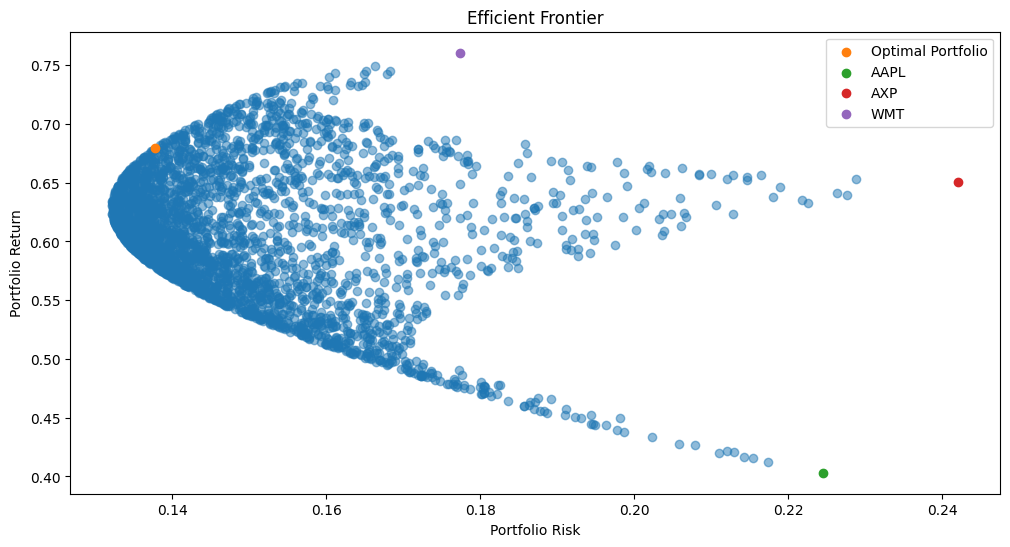

In [3]:
tickers = ['AAPL','WMT','AXP']
start_date = "2024-01-01"
end_date = "2024-12-31"

prices = get_prices(tickers,start_date,end_date)
mean_returns, cov_matrix, rfr = return_characteristics(prices,start_date,end_date)
opt_weights = optimal_weights(mean_returns,cov_matrix,rfr,True)
plot_efficient_frontier(mean_returns,cov_matrix,opt_weights)

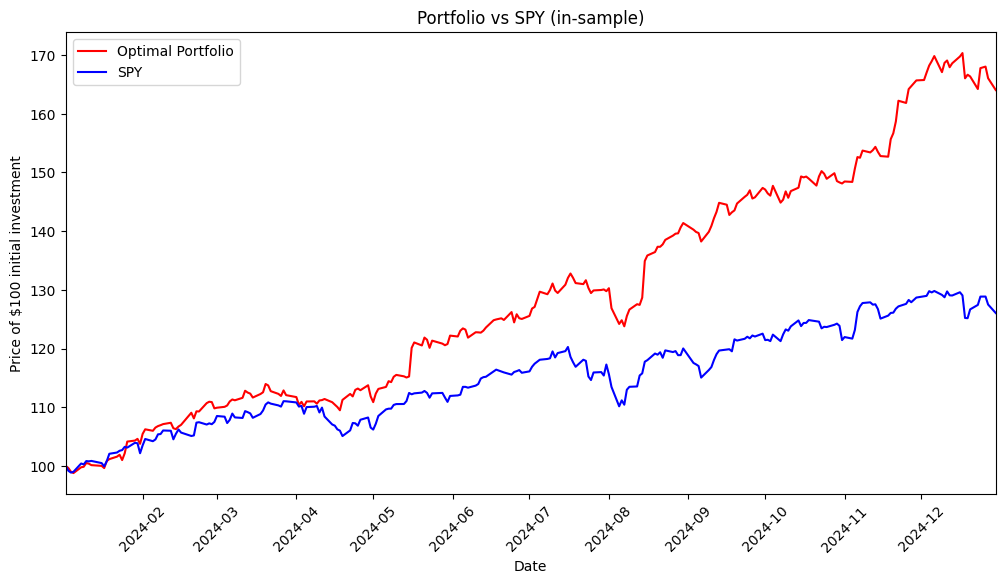

---Holding Period Return---
Optimal Portfolio Return: 64.04%
Benchmark Return: 26.05%


In [4]:
# portfolio performance during in-sample data
plot_performance(tickers,start_date,end_date,opt_weights,title='Portfolio vs SPY (in-sample)')

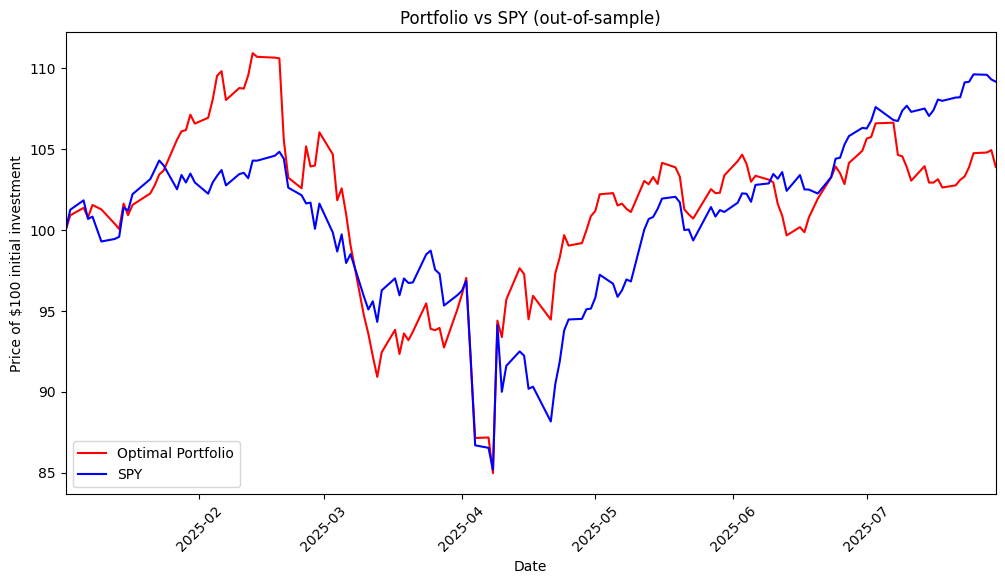

---Holding Period Return---
Optimal Portfolio Return: 3.90%
Benchmark Return: 9.17%


In [5]:
# portfolio performance out-of-sample data
start_date = "2025-01-01"
end_date = "2025-07-31"
plot_performance(tickers,start_date,end_date,opt_weights,title='Portfolio vs SPY (out-of-sample)')